In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from torch.optim import Adam
from tqdm import tqdm
import torch
import dataset_utils as data
import utils as utils

In [2]:
base_dir = "/home/mlsnrs/data/data/lff/ai-lab/lab3/"
data_dir = base_dir + "../../data/"
prefix = "lstm_glove"

if not os.path.exists(f"model/{prefix}"):
    os.makedirs(f"model/{prefix}")

lr = 1e-3
decay = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size= 64
num_workers = 4
num_epochs = 50 # 大约在n=10时 模型过拟合

In [3]:
# Load dataset
# train_set_imdb = data.ImdbDatasetLoader(f"{data_dir}/aclImdb/train")
data_weight = 1.0
train_set_imdb = None
# 
train_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/train.data")
dev_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/valid.data")

# building vocabulary
vocab, idx_to_word = data.build_vocab([
    train_set_imdb if train_set_imdb is not None else []
    , train_set, dev_set])

# word->idx
if train_set_imdb is not None:
    train_set_imdb.convert_word_to_idx(vocab)
train_set.convert_word_to_idx(vocab)
dev_set.convert_word_to_idx(vocab)

# samples: 8596
# samples: 1000


In [4]:
# pretrain words vector
import torchtext.vocab as Vocab

glove_vocab = Vocab.GloVe(name='6B', dim=100, cache=os.path.join(data_dir+"/fudan_nlp/", "glove"))
print(len(glove_vocab.stoi)) # 400000
print(glove_vocab[0].shape)

vocab_weights = data.load_pretrained_embedding(vocab.keys(), glove_vocab)

400000
torch.Size([100])
There are 736 oov words.
['<pad>', '<unk>', '', 'eckstraordinarily', 'cletis', 'swordfights', 'completist', '�the', 'slappingly', 'clichand', 'gantzes', 'surfacey', 'reeboir', 'recurre', 'clich�s', 'g�nero', 'actuaci�n', 'perdona', 'gui�n', 'guessable', 'aceitou', 'continua��o', 'sa�do', 'pesquerdo', 'aqueles', 'decidiram', 'assistir', 'tamb�m', 'unimpressively', 'aborbing', 'histo', 'third�emotionally', 'coriat', 'miscasts', 'likableness', 'contando', 'premissa', 'mergulha', 'culminando', 'desfecho', 'certamente', 'mem�ria', 'enrapturing', 'clich�d', 'nonjudgmentally', 'bottomlessly', 'travil', 'clutchy', 'pistoled', 'vocsinta', 'necessidade', 't�rmino', 'proje��o', 'n�o', 'preocupe', 'ningu�m', 'lhe', 'enviarpenas', 'simbolizando', 'covardia', 'birot', 'wifty', 'wisegirls', 'nrelentingly', 'jirhubac', 'rintars', 'gabbiest', 'nonethnic', 'crummles', 'almod�var', 'logra', 'entra�able', 'compasi�n', 'comprensi�n', 'inolvidable', 'shimmeringly', 'schneidermeister

In [5]:
from lstm import LSTMModel

# vocab_weights = data.load_pretrained_embedding(vocab.keys(), glove_vocab)

model =LSTMModel(
    vocab_size=len(vocab),                
    embedding_dim=100, 
    hidden_dim=256, 
    n_layers=1, num_class=2,
    pretrain_weights=vocab_weights,
    dropout=0.5)

print(model)

LSTMModel(
  (dropout): Dropout(p=0.5, inplace=False)
  (embd): Embedding(17540, 100)
  (constant_embd): Embedding(17540, 100)
  (lstm): LSTM(200, 256, batch_first=True, bidirectional=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
  (loss_ce): CrossEntropyLoss()
)


In [6]:
model.to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=decay) 


# train
loss_tr_his , acc_tr_his = [],[]
loss_dev_his , acc_dev_his = [],[]

the_best = {'eval_acc': 100,
            'model_path':''}

In [7]:
import utils as utils
loss_aux_his , acc_aux_his = [],[]

In [8]:
# train_set = dev_set
for epo in range(num_epochs): 
    # train once in imdb if not none
    # train once in fudan dataset
    if train_set_imdb is not None:
        (batch_avg_loss, batch_avg_acc),(
            l_,a_) = utils.train_batch_cross_domain(
            model, train_set, train_set_imdb, batch_size, num_workers, device,
            optimizer, weighted=data_weight)
            
        loss_aux_his.append(l_)
        acc_aux_his.append(a_)
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)

    else:
        batch_avg_loss, batch_avg_acc = utils.train_batch(
            model, train_set, batch_size, num_workers, device,
            optimizer)    
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)


    # eval once
    eval_loss, eval_acc, _, __ = utils.eval(model, dev_set, batch_size, num_workers, device)
    loss_dev_his.append(eval_loss)
    acc_dev_his.append(eval_acc)

    print(f"epoch[{epo}]  tr_loss: {batch_avg_loss}   tr_acc: {batch_avg_acc}   eval_loss: {eval_loss}   eval_acc: {eval_acc}")

    # save
    if eval_acc >= max(acc_dev_his):
        the_best['model_path'] =  f"model/{prefix}_best.pth"
        the_best['eval_acc'] =  eval_acc
        
        torch.save(model, the_best['model_path'])
        
        print(f"ckp: save as { the_best['model_path'] }, acc {the_best['eval_acc']}")

100%|██████████| 135/135 [00:02<00:00, 56.94it/s]


epoch[0]  tr_loss: 0.6408243214906152   tr_acc: 0.6291298278268962   eval_loss: 0.5848590950171153   eval_acc: 0.72
ckp: save as model/lstm_glove_best.pth, acc 0.72


100%|██████████| 135/135 [00:02<00:00, 65.61it/s]


epoch[1]  tr_loss: 0.5809230920094163   tr_acc: 0.6959050721265705   eval_loss: 0.5926105697949727   eval_acc: 0.713


100%|██████████| 135/135 [00:02<00:00, 65.35it/s]


epoch[2]  tr_loss: 0.5583545118570328   tr_acc: 0.7096323871568171   eval_loss: 0.571415764093399   eval_acc: 0.727
ckp: save as model/lstm_glove_best.pth, acc 0.727


100%|██████████| 135/135 [00:02<00:00, 65.08it/s]


epoch[3]  tr_loss: 0.5413643575426358   tr_acc: 0.7275476966030712   eval_loss: 0.5510113358497619   eval_acc: 0.743
ckp: save as model/lstm_glove_best.pth, acc 0.743


100%|██████████| 135/135 [00:02<00:00, 65.55it/s]


epoch[4]  tr_loss: 0.532680160296497   tr_acc: 0.7367380176826431   eval_loss: 0.5324312547842661   eval_acc: 0.766
ckp: save as model/lstm_glove_best.pth, acc 0.766


100%|██████████| 135/135 [00:02<00:00, 66.23it/s]


epoch[5]  tr_loss: 0.519707045893171   tr_acc: 0.7419730107026524   eval_loss: 0.5335836927096049   eval_acc: 0.751


100%|██████████| 135/135 [00:02<00:00, 64.22it/s]


epoch[6]  tr_loss: 0.5070522514297001   tr_acc: 0.7515123313168915   eval_loss: 0.503728574514389   eval_acc: 0.777
ckp: save as model/lstm_glove_best.pth, acc 0.777


100%|██████████| 135/135 [00:02<00:00, 66.81it/s]


epoch[7]  tr_loss: 0.49002605854575315   tr_acc: 0.7665193113075849   eval_loss: 0.4855394502480825   eval_acc: 0.78
ckp: save as model/lstm_glove_best.pth, acc 0.78


100%|██████████| 135/135 [00:02<00:00, 67.12it/s]


epoch[8]  tr_loss: 0.4884904385057848   tr_acc: 0.7629129827826896   eval_loss: 0.4907700717449188   eval_acc: 0.792
ckp: save as model/lstm_glove_best.pth, acc 0.792


100%|██████████| 135/135 [00:02<00:00, 65.05it/s]


epoch[9]  tr_loss: 0.4759392104486921   tr_acc: 0.7744299674267101   eval_loss: 0.46221482356389365   eval_acc: 0.782


100%|██████████| 135/135 [00:02<00:00, 65.75it/s]


epoch[10]  tr_loss: 0.46354102532365427   tr_acc: 0.7797812936249419   eval_loss: 0.5382936894893646   eval_acc: 0.744


100%|██████████| 135/135 [00:02<00:00, 67.19it/s]


epoch[11]  tr_loss: 0.4511855898508385   tr_acc: 0.787691949744067   eval_loss: 0.45860855976740517   eval_acc: 0.795
ckp: save as model/lstm_glove_best.pth, acc 0.795


100%|██████████| 135/135 [00:02<00:00, 64.94it/s]


epoch[12]  tr_loss: 0.4371980026141921   tr_acc: 0.7897859469520707   eval_loss: 0.4474163333574931   eval_acc: 0.8
ckp: save as model/lstm_glove_best.pth, acc 0.8


100%|██████████| 135/135 [00:02<00:00, 64.89it/s]


epoch[13]  tr_loss: 0.4213102692321165   tr_acc: 0.805025593299209   eval_loss: 0.4763224343458811   eval_acc: 0.783


100%|██████████| 135/135 [00:02<00:00, 64.87it/s]


epoch[14]  tr_loss: 0.41782153686925544   tr_acc: 0.8067705909725453   eval_loss: 0.4516883671283722   eval_acc: 0.794


100%|██████████| 135/135 [00:01<00:00, 70.71it/s]


epoch[15]  tr_loss: 0.4096435886710437   tr_acc: 0.8056072591903211   eval_loss: 0.45013693968455   eval_acc: 0.798


100%|██████████| 135/135 [00:02<00:00, 65.25it/s]


epoch[16]  tr_loss: 0.3975547140658791   tr_acc: 0.8177059097254537   eval_loss: 0.45366310874621074   eval_acc: 0.805
ckp: save as model/lstm_glove_best.pth, acc 0.805


100%|██████████| 135/135 [00:02<00:00, 66.93it/s]


epoch[17]  tr_loss: 0.37755594291348954   tr_acc: 0.8281758957654723   eval_loss: 0.4632357358932495   eval_acc: 0.793


100%|██████████| 135/135 [00:02<00:00, 67.19it/s]


epoch[18]  tr_loss: 0.3666797691761558   tr_acc: 0.8346905537459284   eval_loss: 0.523641840616862   eval_acc: 0.782


100%|██████████| 135/135 [00:01<00:00, 68.77it/s]


epoch[19]  tr_loss: 0.34735554645755395   tr_acc: 0.8452768729641694   eval_loss: 0.5045683642228445   eval_acc: 0.799


100%|██████████| 135/135 [00:02<00:00, 64.32it/s]


epoch[20]  tr_loss: 0.33391426726063683   tr_acc: 0.8510935318752908   eval_loss: 0.47142004569371543   eval_acc: 0.794


100%|██████████| 135/135 [00:02<00:00, 67.19it/s]


epoch[21]  tr_loss: 0.3283762848421709   tr_acc: 0.8523731968357375   eval_loss: 0.4637884497642517   eval_acc: 0.793


100%|██████████| 135/135 [00:02<00:00, 66.52it/s]


epoch[22]  tr_loss: 0.316819507906686   tr_acc: 0.8608655188459748   eval_loss: 0.47895354628562925   eval_acc: 0.793


100%|██████████| 135/135 [00:02<00:00, 65.09it/s]


epoch[23]  tr_loss: 0.3084591698290697   tr_acc: 0.8644718473708701   eval_loss: 0.4608675897121429   eval_acc: 0.786


100%|██████████| 135/135 [00:01<00:00, 68.83it/s]


epoch[24]  tr_loss: 0.29061389080624084   tr_acc: 0.8738948348068869   eval_loss: 0.49667588075002034   eval_acc: 0.802


100%|██████████| 135/135 [00:02<00:00, 66.46it/s]


epoch[25]  tr_loss: 0.2822722156546009   tr_acc: 0.8778501628664495   eval_loss: 0.5221136689186097   eval_acc: 0.79


100%|██████████| 135/135 [00:02<00:00, 65.91it/s]


epoch[26]  tr_loss: 0.27210744103389   tr_acc: 0.8855281526291299   eval_loss: 0.5448328455289205   eval_acc: 0.793


100%|██████████| 135/135 [00:02<00:00, 65.46it/s]


epoch[27]  tr_loss: 0.26115652696410224   tr_acc: 0.8902978129362494   eval_loss: 0.530126029253006   eval_acc: 0.786


100%|██████████| 135/135 [00:02<00:00, 62.02it/s]


epoch[28]  tr_loss: 0.25557915037914886   tr_acc: 0.895067473243369   eval_loss: 0.5448059499263763   eval_acc: 0.806
ckp: save as model/lstm_glove_best.pth, acc 0.806


100%|██████████| 135/135 [00:01<00:00, 68.06it/s]


epoch[29]  tr_loss: 0.2324496056717723   tr_acc: 0.9068171242438343   eval_loss: 0.5846888462702433   eval_acc: 0.792


100%|██████████| 135/135 [00:01<00:00, 68.67it/s]


epoch[30]  tr_loss: 0.22623703567616976   tr_acc: 0.9090274546300605   eval_loss: 0.5661225736141204   eval_acc: 0.796


100%|██████████| 135/135 [00:02<00:00, 65.56it/s]


epoch[31]  tr_loss: 0.2264387594786153   tr_acc: 0.9096091205211726   eval_loss: 0.5626257499059041   eval_acc: 0.798


100%|██████████| 135/135 [00:01<00:00, 68.15it/s]


epoch[32]  tr_loss: 0.20581820801790082   tr_acc: 0.9148441135411819   eval_loss: 0.5662892897923787   eval_acc: 0.799


100%|██████████| 135/135 [00:01<00:00, 68.38it/s]


epoch[33]  tr_loss: 0.2070906127233114   tr_acc: 0.9155421126105165   eval_loss: 0.611738532781601   eval_acc: 0.778


100%|██████████| 135/135 [00:02<00:00, 67.30it/s]


epoch[34]  tr_loss: 0.20490297180280756   tr_acc: 0.9157747789669614   eval_loss: 0.6193008720874786   eval_acc: 0.777


100%|██████████| 135/135 [00:02<00:00, 66.19it/s]


epoch[35]  tr_loss: 0.1822761461249928   tr_acc: 0.9265937645416473   eval_loss: 0.6511335213979085   eval_acc: 0.779


100%|██████████| 135/135 [00:02<00:00, 67.09it/s]


epoch[36]  tr_loss: 0.17945742101144435   tr_acc: 0.9308980921358772   eval_loss: 0.6626805504163106   eval_acc: 0.789


100%|██████████| 135/135 [00:02<00:00, 65.72it/s]


epoch[37]  tr_loss: 0.17542083291753904   tr_acc: 0.9284550953932061   eval_loss: 0.7402694781621297   eval_acc: 0.771


100%|██████████| 135/135 [00:02<00:00, 65.31it/s]


epoch[38]  tr_loss: 0.17576177707358973   tr_acc: 0.9271754304327594   eval_loss: 0.6587273955345154   eval_acc: 0.773


100%|██████████| 135/135 [00:01<00:00, 69.08it/s]


epoch[39]  tr_loss: 0.16304206550677322   tr_acc: 0.9346207538389949   eval_loss: 0.6854130446910858   eval_acc: 0.784


100%|██████████| 135/135 [00:02<00:00, 60.96it/s]


epoch[40]  tr_loss: 0.16115642169407055   tr_acc: 0.9363657515123314   eval_loss: 0.6845559338728587   eval_acc: 0.78


100%|██████████| 135/135 [00:02<00:00, 66.83it/s]


epoch[41]  tr_loss: 0.15432942655882728   tr_acc: 0.9390414146114472   eval_loss: 0.6794686635335286   eval_acc: 0.781


100%|██████████| 135/135 [00:01<00:00, 68.21it/s]


epoch[42]  tr_loss: 0.15195846818943523   tr_acc: 0.9402047463936715   eval_loss: 0.7236401855945587   eval_acc: 0.788


100%|██████████| 135/135 [00:02<00:00, 62.90it/s]


epoch[43]  tr_loss: 0.14071539302926456   tr_acc: 0.9446254071661238   eval_loss: 0.7465062340100607   eval_acc: 0.799


100%|██████████| 135/135 [00:01<00:00, 67.56it/s]


epoch[44]  tr_loss: 0.14572525641589024   tr_acc: 0.9438110749185668   eval_loss: 0.8630492846171062   eval_acc: 0.795


100%|██████████| 135/135 [00:01<00:00, 69.25it/s]


epoch[45]  tr_loss: 0.1317979212183116   tr_acc: 0.9488134015821312   eval_loss: 0.7951531052589417   eval_acc: 0.781


100%|██████████| 135/135 [00:02<00:00, 64.78it/s]


epoch[46]  tr_loss: 0.13762729445388958   tr_acc: 0.9478827361563518   eval_loss: 0.7581445813179016   eval_acc: 0.788


100%|██████████| 135/135 [00:01<00:00, 72.40it/s]


epoch[47]  tr_loss: 0.12430468561655994   tr_acc: 0.9503257328990228   eval_loss: 0.7362368822097778   eval_acc: 0.794


100%|██████████| 135/135 [00:01<00:00, 68.33it/s]


epoch[48]  tr_loss: 0.11634246650527218   tr_acc: 0.9555607259190321   eval_loss: 0.7762550512949625   eval_acc: 0.779


100%|██████████| 135/135 [00:02<00:00, 65.66it/s]


epoch[49]  tr_loss: 0.11666361025687474   tr_acc: 0.9530013959981387   eval_loss: 0.8213044722874959   eval_acc: 0.76


In [9]:
def test_and_write(_data_iter, type="test"):
    preds= []

    for step, _batch in tqdm(enumerate(_data_iter)):
        model.eval()
        x,y=_batch
        with torch.no_grad():
            loss, pred = model(x.to(device), y.to(device))
            pred = pred.detach().cpu().numpy().tolist()
            preds.extend(pred)

    print(f'# {type} pred:', preds)

    with open(f'model/{prefix}/{type}_{len(loss_tr_his)}_res.txt',encoding="utf-8", mode='w') as f:
        for pred in preds:
            f.write("positive" if pred==1 else 'negative')
            f.write('\n')


## load the best model
model = torch.load(the_best['model_path'])


## 写出test结果到txt
test_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/test.data",test=True)

test_set.convert_word_to_idx(vocab)

test_data_iter=test_set.get_sequential_iter(batch_size, num_workers)
test_and_write(test_data_iter,type="test")

dev_data_iter= dev_set.get_sequential_iter(batch_size, num_workers)
test_and_write(dev_data_iter,type="valid")

# samples: 1066


17it [00:00, 83.64it/s] 

# test pred: [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,


16it [00:00, 100.18it/s]

# valid pred: [1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_(losses:dict, acces:dict, save=None):
    num_fig = 2
    plt.figure(num_fig, figsize=(8, 8))
    plt.grid(True)
    
    plt.subplot(num_fig, 1, 1)

    data_f = pd.DataFrame(losses)
    sns.scatterplot(data=data_f)


    plt.subplot(num_fig, 1, 2)
    data_f = pd.DataFrame(acces)
    sns.scatterplot(data=data_f)
    
    plt.savefig(save)

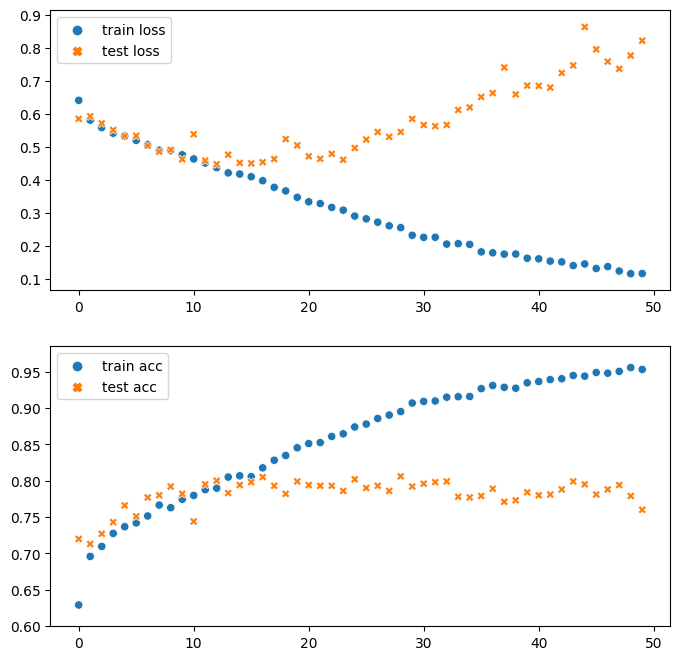

In [11]:
def plot():
    def get_cpu(tuples):
        new_his = []
        for t in tuples:
            new_his.append(t.cpu().item())
        return new_his

    ls = {"train loss":loss_tr_his,
          "test loss":loss_dev_his,
        #   "aux train loss": loss_aux_his
        }

    accs = {"train acc":acc_tr_his,
          "test acc":acc_dev_his,
        #   "aux train acc": acc_aux_his
        }
    plot_(ls, accs,  save =
          f"model/{prefix}/{len(acc_tr_his)}-{the_best['eval_acc']}.png")


plot()

In [12]:
print("best eval loss:", min(loss_dev_his))
print("best eval acc:", max(acc_dev_his))

print("best train loss:", min(loss_tr_his))
print("best train acc:", max(acc_tr_his))

best eval loss: 0.4474163333574931
best eval acc: 0.806
best train loss: 0.11634246650527218
best train acc: 0.9555607259190321
